#Open Library Analysis - Big Data Computing Project
####Graph's Connected Components vs. k-means Clusters

In this notebook we analyse Open Library's data dumps freely downloadable from their website. https://openlibrary.org/developers/dumps
Books' data is probided in JSON records, which we preprocessed so as to keep only relevant information into a .csv file.

In the following we will clean the dataset and extract relevant features.

We use the resulting dataset to create a graph representing books affinity (i.e. nodes represent books and an edge connects two nodes only if their similarity is above a certain threshold). We are then interested in finding then connected components of such graph. 

Moreover, we will perform k-means clustering and compare, in terms of Silhouette Coefficient, the resulting clusters with the connected components of the aforementioned graph.

##Libraries

In [0]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark import SparkContext, SparkConf

# Tokenizer, StopWordsRemover, Word2Vec is for nlp
# VectorAssembler is for joining multiple vectors
# Normalizer is for computing cosine similarity
# StandardScaler is for PCA
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, VectorAssembler, Normalizer, StandardScaler, PCA
from nltk.stem.snowball import SnowballStemmer
# K-means and K-means evaluation
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
# Graph
from graphframes import *

##Data Aquisition

It is possible to download the full dataset (22.589.356 entries) or only the first 50000 entries

short dataset: 50000 entries

In [0]:
%sh wget -P /tmp https://raw.githubusercontent.com/attennig/BDC_datasets/main/books_short.csv

In [0]:
dbutils.fs.mv("file:/tmp/books_short.csv", "dbfs:/bdc-2020-21/datasets/books_short.csv")

long dataset: 22.589.356 entries

In [0]:
%sh wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G" -O /tmp/books_long.csv.bz2 && rm -rf /tmp/cookies.txt

In [0]:
dbutils.fs.ls("file:/tmp")

In [0]:
dbutils.fs.mv("file:/tmp/books_long.csv.bz2", "dbfs:/bdc-2020-21/datasets/books_long.csv.bz2")

In [0]:
dbutils.fs.ls("dbfs:/bdc-2020-21/datasets")

###Load data into pyspark DataFrame

In [0]:
# Read dataset file into a Spark Dataframe
books_df = spark.read.load("dbfs:/bdc-2020-21/datasets/books_short.csv", 
                         format="csv", 
                         sep=";", 
                         inferSchema="true", 
                         header="true"
                         )

In [0]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(books_df.count(), len(books_df.columns)))

The shape of the dataset is 50000 rows by 17 columns

##Data Cleaning

In [0]:
'''columns_to_drop = []
for c in books_df.columns:
  if books_df.where(col(c).isNull()).count()/books_df.count() > 0.7:
    columns_to_drop += [c]
books_df = books_df.drop(*columns_to_drop)'''

Out[68]: 'columns_to_drop = []\nfor c in books_df.columns:\n if books_df.where(col(c).isNull()).count()/books_df.count() > 0.7:\n columns_to_drop += [c]\nbooks_df = books_df.drop(*columns_to_drop)'

In [0]:
books_df = books_df.select("key", "title", "authors", "subjects")

In [0]:
assert "title" in books_df.columns and "key" in books_df.columns
books_df = books_df.dropna(how="any", subset=["key", "title"])
books_df = books_df.dropDuplicates(['key'])
books_df = books_df.dropDuplicates(['title'])

In [0]:
assert "subjects" in books_df.columns and "authors" in books_df.columns
books_df = books_df.na.fill({'subjects': 'unknown', 'authors': 'unknown'})

In [0]:
# This will return a new DF with all the columns + id
books_df = books_df.select("key","title","authors","subjects", row_number().over(Window.partitionBy().orderBy(books_df['key'])).alias("id"))

In [0]:
# From Document_Clustering.ipynb
def clean_text(df, column_name, perform_stemming=True):
    """ 
    This function takes the raw text data and applies a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline
    """
    # Text preprocessing pipeline
    # 1. Text cleaning
    # 1.a Case normalization
    lower_case_df = df.select(["id",lower(col(column_name)).alias(column_name)])
    # 1.b Trimming
    trimmed_df = lower_case_df.select(["id",trim(col(column_name)).alias(column_name)])
    # 1.c Filter out punctuation symbols
    no_punct_df = trimmed_df.select(["id",(regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name)])
    # 1.d Filter out any internal extra whitespace
    cleaned_df = no_punct_df.select(["id",trim(regexp_replace(col(column_name), " +", " ")).alias(column_name)])
    # 2. Tokenization (split text into tokens)
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_df).cache()
    # 3. Stopwords removal
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    ret_df = stopwords_remover.transform(tokens_df).cache()
    # 4. Stemming (Snowball stemmer)
    if perform_stemming:
      stemmer = SnowballStemmer(language="english")
      stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
      ret_df = ret_df.withColumn("terms_stemmed", stemmer_udf("terms")).cache()
      
    return ret_df

In [0]:
clean_title_df = clean_text(books_df, "title")
clean_subjects_df = clean_text(books_df, "subjects")
clean_authors_df = clean_text(books_df, "authors", False)

##Feature Engineering

In this section we will use nlp techniques to get numerical vectors that represent text-based features

In [0]:
RANDOM_SEED = 42 # used below to run the actual K-means clustering

In [0]:
#Word2Vec from Document_Clustering.ipynb 
def extract_w2v_features(df, column_name, out_col_name, EMBEDDING_SIZE = 20):
  word2vec = Word2Vec(vectorSize=EMBEDDING_SIZE, minCount=5, inputCol=column_name, outputCol=out_col_name, seed=RANDOM_SEED)
  model = word2vec.fit(df)
  features = model.transform(df).cache()
  
  return features

In [0]:
w2v_title_features = extract_w2v_features(clean_title_df, "terms_stemmed", "title_vec").select(["id", "title_vec"])

In [0]:
w2v_subjects_features = extract_w2v_features(clean_subjects_df, "terms_stemmed", "subjects_vec").select(["id", "subjects_vec"])

In [0]:
w2v_authors_features = extract_w2v_features(clean_authors_df, "terms", "authors_vec", 10).select(["id", "authors_vec"])

In [0]:
engineered_books_df = w2v_title_features
engineered_books_df = engineered_books_df.join(w2v_subjects_features, ["id"])
engineered_books_df = engineered_books_df.join(w2v_authors_features, ["id"])

In [0]:
vec_ass = VectorAssembler(inputCols=["title_vec","subjects_vec","authors_vec"], outputCol="features", handleInvalid="keep")
engineered_books_df = vec_ass.transform(engineered_books_df).select(["id", "features"])

In [0]:
N_ENTRIES = 1000
short_df = engineered_books_df.filter(col("id")<=N_ENTRIES).cache()

In [0]:
sim_udf = udf(lambda x,y: float(x.dot(y))/float(x.norm(2)*y.norm(2)), DoubleType())
sim_df = short_df.alias("src").join(short_df.alias("dst"), col("src.id") != col("dst.id"))\
    .select(
        col("src.ID").alias("src"), 
        col("dst.ID").alias("dst"), 
        sim_udf("src.features", "dst.features").alias("cos_sim"))\
    .sort(desc("cos_sim")).cache()

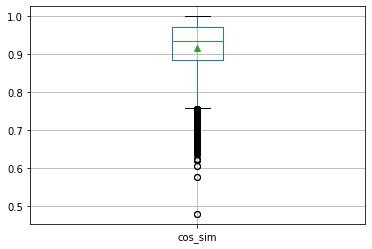

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

plot_df = sim_df.toPandas()
plot_df.boxplot(column=["cos_sim"], showmeans=True)

plt.show()

In [0]:
median_cos_sim = plot_df.median(axis=0)["cos_sim"]
#mean_cos_sim = float(sim_df.describe(['cos_sim']).collect()[1]['cos_sim'])
mean_cos_sim = plot_df.mean(axis=0)["cos_sim"]
print(f"The mean cosine similarity is {mean_cos_sim}, the median is {median_cos_sim}")

The mean cosine similarity is 0.9176801154700202, the median is 0.9346693712236698

##Graph

In [0]:
nodes_df = short_df.select(["id"]).cache()

In [0]:
SIM_THRESHOLD = mean_cos_sim if mean_cos_sim > median_cos_sim else median_cos_sim # max(mean, median)
edges_df = sim_df.filter(sim_df.cos_sim>SIM_THRESHOLD).cache()

In [0]:
books_graph = GraphFrame(nodes_df, edges_df)

In [0]:
#books_graph.vertices.count()

In [0]:
#books_graph.edges.count()

In [0]:
#!pwd

In [0]:
#!mkdir /databricks/driver/checkpoints

In [0]:
spark.sparkContext.setCheckpointDir('/databricks/driver/checkpoints')

In [0]:
# books_CC is a dataframe with vertices column and components column
books_CC = books_graph.connectedComponents()

In [0]:
books_CC.show()

+---+---------+
 id|component|
+---+---------+
 1| 1|
 2| 1|
 3| 1|
 4| 1|
 5| 1|
 6| 1|
 7| 1|
 8| 1|
 9| 1|
 10| 1|
 11| 1|
 12| 1|
 13| 1|
 14| 1|
 15| 1|
 16| 1|
 17| 1|
 18| 1|
 19| 1|
 20| 20|
+---+---------+
only showing top 20 rows

In [0]:
n_CC = books_CC.select("component").dropDuplicates(["component"]).count()
print(f'we have {n_CC} connected components')

we have 6 connected components

##Clustering

In [0]:
# from Document_Clustering.ipynb  e l'altro del clustering
# k = nCC , kmeans
MAX_ITERATIONS = 100 # maximum number of iterations of K-means EM algorithm
TOLERANCE = 0.000001 # tolerance between consecutive centroid updates (i.e., another stopping criterion)

PCA not used atm

In [0]:
'''scaler = StandardScaler(inputCol="features", 
                        outputCol="std_vector_features",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(engineered_books_df)

# Normalize each feature to have unit standard deviation.
engineered_books_df = scalerModel.transform(engineered_books_df)'''

In [0]:
'''n_PC = 10
pca_model = PCA(k=n_PC, inputCol="std_vector_features", outputCol="pca_features")
pca_features = pca_model.fit(engineered_books_df)
pca_books_df = pca_features.transform(engineered_books_df).cache()'''

In [0]:
def k_means(dataset, 
            n_clusters, 
            distance_measure, 
            max_iter=MAX_ITERATIONS, 
            tol=TOLERANCE,
            features_col="features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):

  print("""Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=tol, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset).cache()

  return model, clusters_df

In [0]:
model, clusters_df = k_means(short_df, n_CC, max_iter=MAX_ITERATIONS, distance_measure="cosine")

Training K-means clustering using the following parameters: 
 - K (n. of clusters) = 6
 - max_iter (max n. of iterations) = 100
 - distance measure = cosine
 - random seed = 42

##Evaluation

In [0]:
metric_name="silhouette"
distance_measure="cosine" #"squaredEuclidean"

###Graph's connected components evaluation

In [0]:
components_df = books_CC.alias("comp").join(short_df.alias("orig").select("id", "features"), col("comp.id") == col("orig.id")).select("orig.id", "features", "component")

In [0]:
prediction_col="component"

evaluator = ClusteringEvaluator(metricName=metric_name,
                                distanceMeasure=distance_measure, 
                                predictionCol=prediction_col
                                )
evaluator.evaluate(components_df)

Out[112]: 0.337184902504516

###Clusters evaluation

In [0]:
# Evaluate clustering by computing Silhouette score
prediction_col="cluster"
evaluator = ClusteringEvaluator(metricName=metric_name,
                                distanceMeasure=distance_measure, 
                                predictionCol=prediction_col
                                )
evaluator.evaluate(clusters_df)

Out[113]: 0.5387953971936456